In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib import image

EAST_POINT = -113.8
WEST_POINT = -124.49
NORTH_POINT = 42.05
SOUTH_POINT = 32.45

In [162]:
def plot_lat_long(df, s=4, c='b',
    save_file_path=None, 
    cal_pic_file_path='california.png'):
    """ Function to plot lat / long points on california map"""
    image_array = image.imread(cal_pic_file_path)
    _, ax = plt.subplots(figsize=(10,8))
    extent = [WEST_POINT, EAST_POINT, SOUTH_POINT, NORTH_POINT]
    ax.imshow(image_array, extent=extent)
    for _, row in df.iterrows():
        ax.scatter(row['lon'], row['lat'], c=c, s=s)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)
    if save_file_path is not None:
        plt.savefig(save_file_path)
    plt.show()

def filter_df(df, cities, in_bool):
    if in_bool:
        comparison = lambda x: x in cities
    else:
        comparison = lambda x: x not in cities
    valid_idx = []
    for idx, row in df.iterrows():
        if comparison(row['city']):
            valid_idx.append(idx)
    return df.loc[valid_idx]

def choose_next_city(ca_all, city_list):
    
    chosen_df = filter_df(ca_all, city_list, in_bool=True)
    eligable_df = filter_df(ca_all, city_list, in_bool=False)

    loc1 = eligable_df[['lat','lon']].values
    loc2 = chosen_df[['lat','lon']].values

    min_distances = np.min(cdist(loc1, loc2) ** 2.5, axis=1)
    populations = eligable_df['population'].values ** 0.2
    min_distances *= populations
    cum_prob = np.cumsum(min_distances / sum(min_distances))

    rand = np.random.rand()
    idx = sum(cum_prob < rand)

    return eligable_df.reset_index(drop=True).loc[idx]['city']

100%|██████████| 400/400 [00:25<00:00, 15.86it/s]


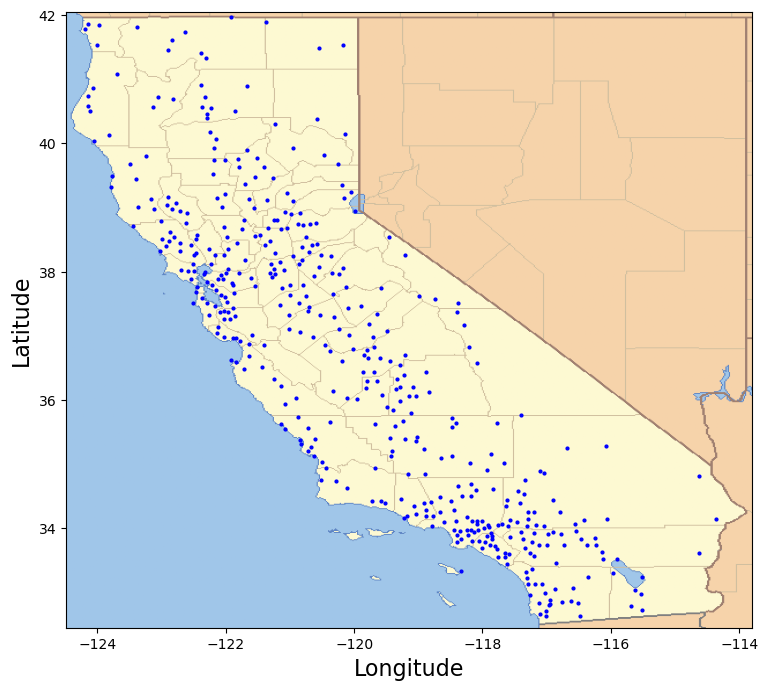

In [171]:
TOP_NUM = 50
KMEAN_PLUS_NUM = 400
RAND_NUM = 0

np.random.seed(123)

loc = pd.read_csv('uscities.csv')

ca_all = loc[loc['state_id'] == 'CA'].reset_index().sort_values('population', ascending=False)
ca_all = ca_all[['city', 'lat', 'lng', 'population']].rename(columns={'lng':'lon'}).round(3)
ca_all = ca_all[ca_all['population'] > 500]

starting_cities = ca_all.head(TOP_NUM)

chosen_cities = list(starting_cities['city'].values)

for _ in tqdm(range(KMEAN_PLUS_NUM)):
    new_city = choose_next_city(ca_all, chosen_cities)
    chosen_cities.append(new_city)

final_df = filter_df(ca_all, chosen_cities, in_bool=True)
final_df = final_df.sort_values('population', ascending=False).reset_index(drop=True)

final_df.to_csv('locations.csv', index=False)

plot_lat_long(final_df, save_file_path='locations.png')